# Employee Review Sentiment Analysis with BERT

__author__ = "Fiodar Ryzhykau"
__version__ = "CS224u, Stanford, Fall 2020"

### Project Outline

**Step 1**: Project Introduction

**Step 2**: Exploratory Data Analysis and Preprocessing

**Step 3**: Training/Validation Split

**Step 4**: Loading BERT Tokenizer and Encoding the Data

**Step 5**: Setting up BERT Pretrained Model

**Step 6**: Creating Data Loaders

**Step 7**: Setting Up Optimizer and Scheduler

**Step 8**: Defining the Performance Metrics

**Step 9**: Training the Model

**Step 10**: Result Evaluation

**Step 11**: Comparing with classic model baselines

## Step 1: Project Introduction


For my Final Project in the Stanford NLU course I’ve selected a topic that is related to the employee assessment in modern companies. In my current company, every quarter (and annually) managers should provide feedback to their team-members and grade their Performance and Potential in order to objectify the value of that employee to the company. 

We use the “9-box model”, which is also called the “Performance and Potential Model” and has been developed by McKinsey. This approach is used in many companies as a method to identify, support and promote the talent. 

 
Feedback (review) that is being submitted along the 9-box grade should explicitly describe all the strong and weak points of the employee, as well as sentiment to the contribution and progress for the given quarter. Submitted data basically represents a mapping/summarization of the feedback to one of the 9 categories.


Models used:
* [HuggingFace models](https://huggingface.co/transformers/model_doc/bert.html)

* [Bert overview](https://characters.fandom.com/wiki/Bert_(Sesame_Street). 
For more information, the original paper can be found [here](https://arxiv.org/abs/1810.04805). 

## Step 2: Exploratory Data Analysis and Preprocessing

Dataset Has been collected from Amazon MTurk.

In [1]:
from google.colab import drive
from google.colab import auth
drive.mount('/content/drive')

Mounted at /content/drive


In [68]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import wordcloud
import os

TRAINED_MODELS_FOLDER = 'trained_models'
if not os.path.exists(TRAINED_MODELS_FOLDER):
    os.makedirs(TRAINED_MODELS_FOLDER)

STATS_FOLDER = 'stats'
if not os.path.exists(STATS_FOLDER):
    os.makedirs(STATS_FOLDER)

ANALYSIS_FOLDER = 'analysis'   
if not os.path.exists(ANALYSIS_FOLDER):
    os.makedirs(ANALYSIS_FOLDER)

In [3]:
pd.set_option('display.max_colwidth', 2000)
df = pd.read_csv('drive/My Drive/Collab_Drive/employee_review_mturk_dataset_13_and_test_v3.1.csv')
df.set_index('id', inplace=True)
df.dropna(inplace=True)

In [4]:
df.head(3)
#df.tail(10)

,person_name,nine_box_category,feedback,performance_class,potential_class,adjusted
id,,,,,,
1,John Doe,"Category 1: 'Risk' (Low performance, Low potential)","John has not progressed in his position. He is continuously late, leaves early, and takes many breaks throughout the day. He calls out at least every other week and it's always on Fridays. His performance has significantly declined. My suggestion is he is not suitable for this position.",1,1,False
2,John Doe,"Category 1: 'Risk' (Low performance, Low potential)","John has consistently disappointed me this quarter with his shoddy work product. I asked him for a report and gave him a lenient two-week deadline, but he blew past that deadline without even informing me. When he finally turned the report in, it was three weeks late and riddled with typos. He did not seem interested in any of the comments that I made on that report, even though I made them for his benefit so he would understand what a high-quality report is supposed to look like.",1,1,False
3,John Doe,"Category 1: 'Risk' (Low performance, Low potential)","John turned in subpar work product all quarter. When I asked him to make revisions, he repeatedly failed to implement the corrections that I had requested. He also seemed confused and lost whenever we had discussions about the reports and the numbers in the data. He was not interested in learning more when I gave him opportunities to participate in trainings. He seems to have already reached his full potential here, which is disappointing given the quality of work I've seen from him.",1,1,False


In [5]:
possible_labels = df.nine_box_category.unique()
possible_labels = np.sort(possible_labels)

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

label_dict_inverse = {v: k for k, v in label_dict.items()}

pp_map = {}
pp_map[0] = [0,0]
pp_map[1] = [1,0]
pp_map[2] = [2,0]
pp_map[3] = [0,1]
pp_map[4] = [1,1]
pp_map[5] = [2,1]
pp_map[6] = [0,2]
pp_map[7] = [1,2]
pp_map[8] = [2,2]

In [6]:
import nltk.data
from nltk import tokenize

nltk.download('punkt')
pass

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
print(f'\nInitial dataset size: {len(df.index)}')

df_upd = df.copy()
df_upd['label'] = df_upd.nine_box_category.replace(label_dict)
df_upd['feedback'] = df_upd.feedback.replace('\\r',' ', regex=True)
df_upd['feedback_len'] = df_upd.feedback.str.len()
df_upd['num_of_sent'] = df_upd.feedback.apply(lambda s: len(tokenize.sent_tokenize(s)))
df_upd['performance_class'] = df_upd.label.apply(lambda l: pp_map[l][0])
df_upd['potential_class'] = df_upd.label.apply(lambda l: pp_map[l][1])

feedback_len_stats = df_upd['feedback_len'].describe(percentiles=[.05,.10,.25,.50,.75,.85,.90,.95])
print(f'\nFeedback len stats: \n{feedback_len_stats}')

num_of_sent_stats = df_upd['num_of_sent'].describe(percentiles=[.05,.10,.25,.50,.75,.85,.90,.95])
print(f'\nFeedback sentence num stats: \n{num_of_sent_stats}')

df_upd = df_upd.loc[(df_upd['feedback_len'] > 150) & (df_upd['feedback_len'] < 600)]
df_upd = df_upd.loc[df_upd['num_of_sent'] > 1]
df_upd = df_upd.loc[~df_upd['feedback'].str.contains('category') & ~df_upd['feedback'].str.contains('Category')]

print(f'\nSize after filtering: {len(df_upd.index)}')

df = df_upd.sort_values(by=['label']).copy()
#df.tail()


Initial dataset size: 923

Feedback len stats: 
count     923.000000
mean      332.780065
std       137.620404
min        59.000000
5%        147.100000
10%       177.000000
25%       237.000000
50%       314.000000
75%       405.000000
85%       480.400000
90%       523.000000
95%       580.900000
max      1060.000000
Name: feedback_len, dtype: float64

Feedback sentence num stats: 
count    923.000000
mean       4.140845
std        1.238259
min        1.000000
5%         2.000000
10%        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
85%        5.000000
90%        5.000000
95%        6.000000
max       24.000000
Name: num_of_sent, dtype: float64

Size after filtering: 803


# 0:


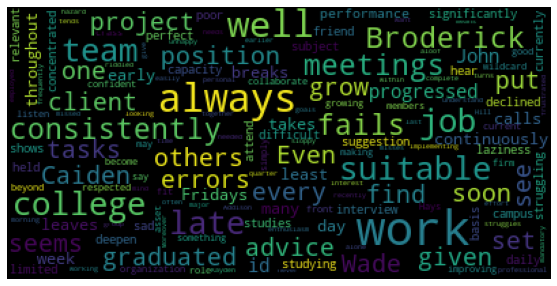

# 1:


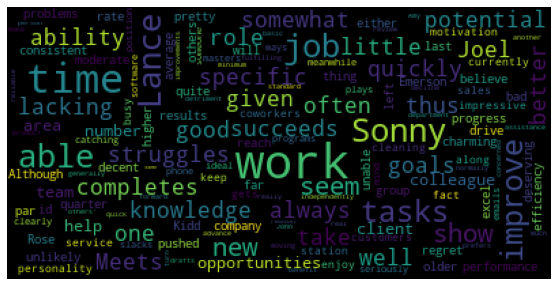

# 2:


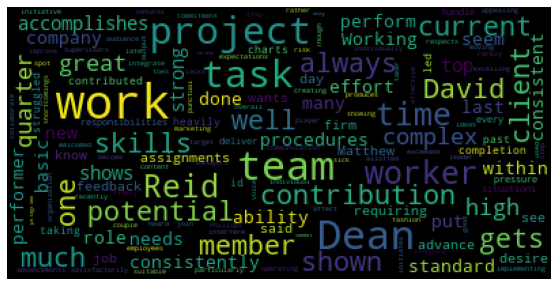

# 3:


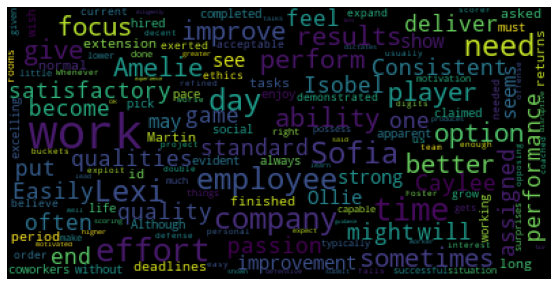

# 4:


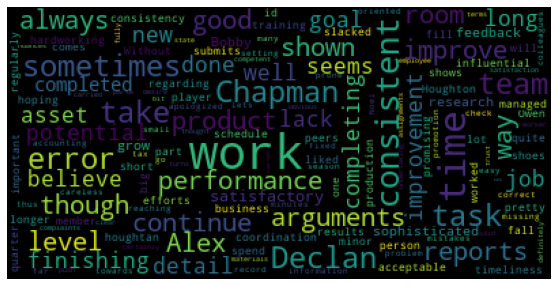

# 5:


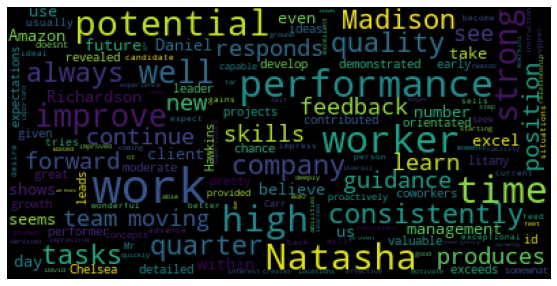

# 6:


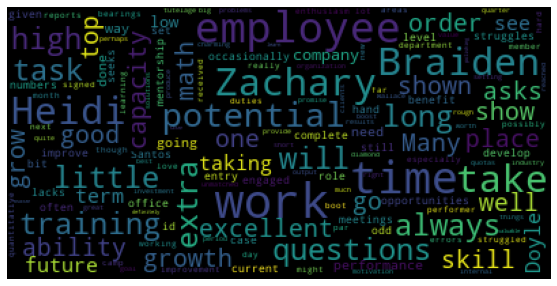

# 7:


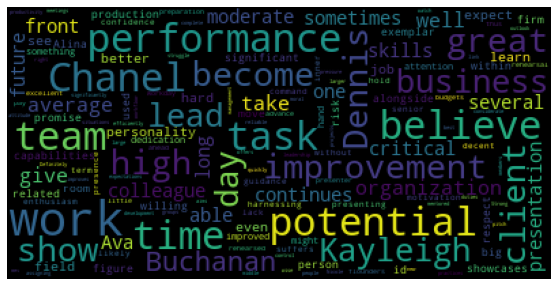

# 8:


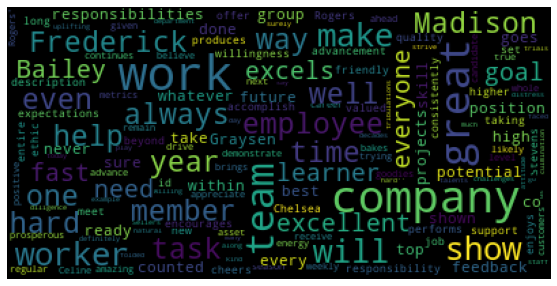

In [72]:
def plot_wordcloud(corpus, description="default", max_words=150, max_font_size=35, figsize=(10,10)):
    wc = wordcloud.WordCloud(background_color='black', max_words=max_words, max_font_size=max_font_size)
    wc = wc.generate(str(corpus)) #if type(corpus) is not dict else wc.generate_from_frequencies(corpus)     
    fig = plt.figure(num=1, figsize=figsize)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.savefig(STATS_FOLDER + f'/{description}_wordcloud.png')
    plt.show()

for label in df.label.unique():
    print("# {}:".format(label))
    plot_wordcloud(corpus=df[df["label"]==label]["feedback"], description=label, max_words=150, max_font_size=35, figsize=(10,5))

In [8]:
#bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
res = df_upd['feedback_len'].value_counts(bins=10, sort=False)
print(f'\nDistribution by len in filtered: \n{res}')


Distribution by len in filtered: 
(150.553, 195.6]     71
(195.6, 240.2]      101
(240.2, 284.8]      136
(284.8, 329.4]      128
(329.4, 374.0]      106
(374.0, 418.6]       90
(418.6, 463.2]       55
(463.2, 507.8]       48
(507.8, 552.4]       38
(552.4, 597.0]       30
Name: feedback_len, dtype: int64


In [9]:
df.performance_class.value_counts().sort_index()

0    271
1    261
2    271
Name: performance_class, dtype: int64

In [10]:
df.potential_class.value_counts().sort_index()

0    294
1    263
2    246
Name: potential_class, dtype: int64

In [11]:
df.nine_box_category.value_counts()

Category 1: 'Risk' (Low performance, Low potential)                        103
Category 3: 'Solid Performer' (High performance, Low potential)            101
Category 5: 'Core Player' (Moderate performance, Moderate potential)        95
Category 9: 'Star' (High performance, High potential)                       92
Category 4: 'Inconsistent Player' (Low performance, Moderate potential)     90
Category 2: 'Average performer' (Moderate performance, Low potential)       90
Category 6: 'High Performer' (High performance, Moderate potential)         78
Category 7: 'Potential Gem' (Low performance, High potential)               78
Category 8: 'High Potential' (Moderate performance, High potential)         76
Name: nine_box_category, dtype: int64

## Step 3: Training/Validation Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['nine_box_category', 'label', 'data_type']).count()
pass

train_df = df[df.data_type=='train']
val_df = df[df.data_type=='val']

## Step 4: Loading BERT Tokenizer and Encoding the Data

In [13]:
!pip install transformers
pass

     |████████████████████████████████| 1.3MB 8.4MB/s 
     |████████████████████████████████| 2.9MB 16.2MB/s 
     |████████████████████████████████| 890kB 60.0MB/s 
     |████████████████████████████████| 1.1MB 42.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=24603ed989d154aa333b2c63a8ca661a05c846dee8b4da2042a98f0a4e546ab8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [14]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [15]:
#bert_type = 'bert-base-cased'
bert_type = 'bert-large-uncased'
convert_to_lowercase=True
tokenizer = BertTokenizer.from_pretrained(bert_type, 
                                          do_lower_case=convert_to_lowercase)

In [16]:
tensor_size=512

encoded_data_train = tokenizer.batch_encode_plus(
    train_df.feedback.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=tensor_size, 
    return_tensors='pt',
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    val_df.feedback.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=tensor_size, 
    return_tensors='pt',
    truncation=True
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.label.values)

In [17]:
train_df.to_csv('train_set.csv')
val_df.to_csv('validation_set.csv')

In [18]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [19]:
print(f'Dataset size full     : {len(dataset_train) + len(dataset_val)}')
print(f'Dataset for training  : {len(dataset_train)}')
print(f'Dataset for validation: {len(dataset_val)}')

Dataset size full     : 803
Dataset for training  : 682
Dataset for validation: 121


## Step 5: Setting up BERT Pretrained Model

In [20]:
from transformers import BertForSequenceClassification

In [21]:
print(f'Num of labels:{len(label_dict)}')
model = BertForSequenceClassification.from_pretrained(bert_type,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



Num of labels:9


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

## Step 6: Creating Data Loaders

In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [23]:
batch_size = 4 #large_bert
#batch_size = 16 #base_bert

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

## Step 7: Setting Up Optimiser and Scheduler

In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [25]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [26]:
#epochs = 40 #base_bert
epochs = 15 #large_bert

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Step 8: Defining the Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [27]:
from sklearn.metrics import f1_score

In [28]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


In [29]:
def get_dataset_id_label_map(input_df):
    labels = input_df.label.unique()
    #print(labels)
    result_map = dict()
    for label in labels:
        rows_with_labels = input_df.loc[input_df['label'] == label]
        ids = rows_with_labels.index
        #print(f'Label {label} ids: {ids}')
        result_map[label] = ids.copy()
    return result_map

#print(get_dataset_id_label_map(test_df))

In [77]:
def calculate_stats_per_class(preds, labels, input_df=pd.DataFrame()):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    total_correct = 0
    overall_gold = 0
    id_map = get_dataset_id_label_map(input_df)   
    output_df  = input_df.copy()    
    all_predictions = np.array([])
    

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]  
        print(f'Class: {label_dict_inverse[label]}')

        all_predictions = np.concatenate((all_predictions, y_preds), axis=0)

        correct = len(y_preds[y_preds==label])
        total_correct += correct
        num_of_gold = len(y_true)
        overall_gold += num_of_gold

        print(f'Predictions: {y_preds}')
        print(f'Gold Values: {y_true}')
        print(f'Ids: {id_map[label]}')
       
        print(f'Accuracy: {correct}/{num_of_gold}  ' + '{:.2f}\n'.format(correct/num_of_gold))  

    print(f'AVG Accuracy: {total_correct}/{overall_gold}  '+ '{:.2f}\n'.format(total_correct/overall_gold))

    output_df['ml_prediction_label'] = pd.Series(all_predictions, index=output_df.index)
    output_df['ml_category'] = output_df.ml_prediction_label.apply(lambda l: label_dict_inverse[l])
    output_df['ml_performance_class'] = output_df.ml_prediction_label.apply(lambda l: pp_map[l][0])
    output_df['ml_potential_class'] = output_df.ml_prediction_label.apply(lambda l: pp_map[l][1])
    output_df['ml_match'] = output_df.apply(lambda row: row.label == row.ml_prediction_label, axis=1)
    output_df['performance_match'] = output_df.apply(lambda row: row.performance_class == row.ml_performance_class, axis=1)
    output_df['potential_match'] = output_df.apply(lambda row: row.potential_class == row.ml_potential_class, axis=1)

    print('Performance Accuracy: {:0.2f}\n'.format(output_df["performance_match"].mean()))
    print('Potential Accuracy: {:0.2f}\n'.format(output_df["potential_match"].mean()))
    
    return output_df

## Step 9: Training the Model

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [31]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [44]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [33]:
def evaluate(dataloader_values, target_model):

    target_model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_values:
        #print(f'batch {batch.size()}')
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        #print(f'input_ids: {batch[0]}')
        #print(f'labels: {batch[2]}')
        with torch.no_grad():        
            outputs = target_model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        #print(f'logits {logits}')
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_values) 

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [34]:
epoch_list = []
train_loss = []
validation_loss = []
f1_scores_weighted = []
#min_epoch_to_save = 30 #base_bert
min_epoch_to_save = 0 #large_bert


for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        #print(f'batch[0] - input_ids: {batch[0].size()}' )
        #print(f'batch[1] - attention_mask: {batch[1].size()}' )
        #print(f'batch[2] - labels: {batch[2].size()}' )
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        #print(f'loss {loss}')
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)             
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation, model)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

    epoch_list.append(epoch)
    train_loss.append(loss_train_avg)
    validation_loss.append(val_loss)
    f1_scores_weighted.append(val_f1)

    if (epoch > min_epoch_to_save):    
        torch.save(model.state_dict(), TRAINED_MODELS_FOLDER + f'/finetuned_BERT_epoch_{epoch}.model')

        df_learning_curve = pd.DataFrame({'epoch': epoch_list,
                      'train_loss_avg': train_loss,
                      'validation_loss': validation_loss,
                      'val_f1_weighted': f1_scores_weighted})

        lc_file_name = STATS_FOLDER + f'/learning_curve_{epoch}.csv'
        df_learning_curve.to_csv(lc_file_name, index=False)



Epoch 1
Training loss: 2.1706252397849544
Validation loss: 1.7876261818793513
F1 Score (Weighted): 0.34270325484624925



Epoch 2
Training loss: 1.6086471317804347
Validation loss: 1.3449938076157724
F1 Score (Weighted): 0.4918374827465737



Epoch 3
Training loss: 1.100080660037827
Validation loss: 1.2438092717239935
F1 Score (Weighted): 0.4989918290109336



Epoch 4
Training loss: 0.6480382151945293
Validation loss: 1.161737147358156
F1 Score (Weighted): 0.6005744259615452



Epoch 5
Training loss: 0.29467983955615445
Validation loss: 1.1602265008635098
F1 Score (Weighted): 0.6264604361981293



Epoch 6
Training loss: 0.1364345380774977
Validation loss: 1.1953139566185493
F1 Score (Weighted): 0.6471364571346132



Epoch 7
Training loss: 0.03441273266373322
Validation loss: 1.210930469363267
F1 Score (Weighted): 0.7336429130904327



Epoch 8
Training loss: 0.018571637839089796
Validation loss: 1.2297915809284594
F1 Score (Weighted): 0.7504172393855145



Epoch 9
Training loss: 0.0038890825456542057
Validation loss: 1.3408634829252297
F1 Score (Weighted): 0.7401144789267502



Epoch 10
Training loss: 0.002840841118905323
Validation loss: 1.3763567488377673
F1 Score (Weighted): 0.7313730939379272



Epoch 11
Training loss: 0.0019987937238622913
Validation loss: 1.3521713025289617
F1 Score (Weighted): 0.7453460534043237



Epoch 12
Training loss: 0.0017439924672039018
Validation loss: 1.366775597252267
F1 Score (Weighted): 0.7595948349258326



Epoch 13
Training loss: 0.0015296129072738583
Validation loss: 1.3809096235969676
F1 Score (Weighted): 0.7453460534043237



Epoch 14
Training loss: 0.0014402442039889202
Validation loss: 1.3797356192165264
F1 Score (Weighted): 0.7453460534043237



Epoch 15
Training loss: 0.001389298938645039
Validation loss: 1.3773143129918965
F1 Score (Weighted): 0.752937083064319



## Step 10: Result Evaluation

In [35]:
#Preparing Test Set
test_df = pd.read_csv(f'drive/My Drive/Collab_Drive/employee_review_mturk_dataset_test_batch_2_v3.1.csv')
#val_r = test_df.loc[test_df['id'] == 20086].feedback
#print(val_r)
#print(val_r.str.replace(r'\r',' '))

test_df.set_index('id', inplace=True)
test_df.dropna(inplace=True)

test_df['feedback'] = test_df.feedback.replace('\\r',' ', regex=True)
test_df['label'] = test_df.nine_box_category.replace(label_dict)
test_df['performance_class'] = test_df.label.apply(lambda l: pp_map[l][0])
test_df['potential_class'] = test_df.label.apply(lambda l: pp_map[l][1])
test_df = test_df.sort_values(by=['label'])
test_df.to_csv(f'test_set.csv')
#test_df.head()


In [36]:
print(f'Test Set size: {len(test_df)}')
print(f'Num of Test Classes: {test_df.nine_box_category.value_counts()}')

tensor_size=512

encoded_data_test = tokenizer.batch_encode_plus(
    test_df.feedback.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=tensor_size, 
    return_tensors='pt',
    truncation=True
)


input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df.label.values)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

Test Set size: 229
Num of Test Classes: Category 1: 'Risk' (Low performance, Low potential)                        34
Category 2: 'Average performer' (Moderate performance, Low potential)      28
Category 6: 'High Performer' (High performance, Moderate potential)        28
Category 5: 'Core Player' (Moderate performance, Moderate potential)       27
Category 3: 'Solid Performer' (High performance, Low potential)            26
Category 9: 'Star' (High performance, High potential)                      26
Category 8: 'High Potential' (Moderate performance, High potential)        23
Category 4: 'Inconsistent Player' (Low performance, Moderate potential)    21
Category 7: 'Potential Gem' (Low performance, High potential)              16
Name: nine_box_category, dtype: int64


In [37]:
#print(f'Num of classes {len(label_dict)}')
eval_model = BertForSequenceClassification.from_pretrained(bert_type,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

eval_model.to(device)
pass

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [38]:
#eval_model_path = f'drive/My Drive/Collab_Drive/v3.1/finetuned_BERT_epoch_50.model'
eval_model_path = TRAINED_MODELS_FOLDER + f'/finetuned_BERT_epoch_15.model'
#eval_model_path = TRAINED_MODELS_FOLDER + f'/finetuned_BERT_epoch_{epochs}.model'
eval_model.load_state_dict(torch.load(eval_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [78]:
_, val_predictions, true_val_vals = evaluate(dataloader_validation, eval_model)
output_val_df = calculate_stats_per_class(val_predictions, true_val_vals, val_df)
output_val_df.to_csv(ANALYSIS_FOLDER +'/validation_set_analysis.csv')

Class: Category 1: 'Risk' (Low performance, Low potential)
Predictions: [0 3 0 0 0 0 0 0 1 0 0 0 0 0 1]
Gold Values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ids: Int64Index([87, 82, 81, 72, 70, 65, 10046, 10126, 10005, 10168, 10169, 25, 13,
            53, 51],
           dtype='int64', name='id')
Accuracy: 12/15  0.80

Class: Category 2: 'Average performer' (Moderate performance, Low potential)
Predictions: [1 1 4 3 5 1 1 4 1 1 1 1 1 1]
Gold Values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Ids: Int64Index([10212, 10132, 10131, 10130, 10007, 127, 116, 106, 101, 94, 133,
            129, 151, 138],
           dtype='int64', name='id')
Accuracy: 10/14  0.71

Class: Category 3: 'Solid Performer' (High performance, Low potential)
Predictions: [8 2 1 2 2 2 2 2 2 2 2 2 2 2 2]
Gold Values: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Ids: Int64Index([10054, 261, 10011, 220, 223, 225, 236, 239, 243, 249, 216, 181,
            188, 192, 204],
           dtype='int64', name='id')
Accuracy: 13/15  0.87

Class: Category 4: 'Inco

In [79]:
_, test_predictions, true_test_vals = evaluate(dataloader_test, eval_model)
output_test_df = calculate_stats_per_class(test_predictions, true_test_vals, test_df)
output_test_df.to_csv(ANALYSIS_FOLDER +'/test_set_analysis.csv')


Class: Category 1: 'Risk' (Low performance, Low potential)
Predictions: [0 0 0 0 3 3 2 0 2 0 0 0 3 0 0 0 0 0 0 0 0 0 0 1 0 0 0 3 0 0 0 0 0 3]
Gold Values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ids: Int64Index([20001, 20087, 20088, 20089, 20060, 20058, 20028, 20214, 20099,
            20051, 20213, 20212, 20043, 20173, 20172, 20085, 20171, 20126,
            20002, 20003, 20004, 20005, 20047, 20141, 20170, 20046, 20133,
            20044, 20130, 20129, 20128, 20127, 20045, 20186],
           dtype='int64', name='id')
Accuracy: 26/34  0.76

Class: Category 2: 'Average performer' (Moderate performance, Low potential)
Predictions: [2 1 3 3 1 3 1 1 1 1 3 1 1 2 7 1 4 4 1 1 1 1 1 1 2 2 1 6]
Gold Values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Ids: Int64Index([20065, 20179, 20091, 20093, 20094, 20114, 20175, 20174, 20132,
            20134, 20135, 20149, 20090, 20050, 20075, 20048, 20020, 20010,
            20009, 20219, 20217, 20008, 20016, 20

In [41]:
#for data cleanup
#_, train_predictions, true_train_vals = evaluate(dataloader_train, eval_model)
#output_train_df = calculate_stats_per_class(train_predictions, true_train_vals, train_df)
#output_train_df.to_csv('analysis/train_set_analysis.csv')

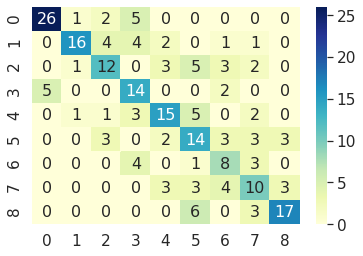

In [45]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

def confusion_matrix_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    unique_labels = np.unique(labels_flat)
    return confusion_matrix(labels_flat, preds_flat, labels=unique_labels)


cm = confusion_matrix_func(test_predictions, true_test_vals)

sn.set(font_scale=1.4)
cm_plot = sn.heatmap(cm, annot=True, annot_kws={"size": 16},cmap="YlGnBu")
cm_plot.get_figure().savefig(STATS_FOLDER + f'/BERT_confusion_matrix.png')    

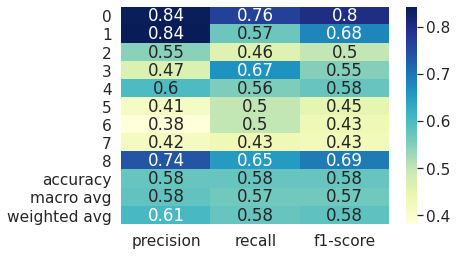

In [47]:
from sklearn.metrics import classification_report

bert_preds_flat = np.argmax(test_predictions, axis=1).flatten()
bert_test_report = classification_report(true_test_vals.flatten(), bert_preds_flat, output_dict=True)
bert_report_plot = sn.heatmap(pd.DataFrame(bert_test_report).iloc[:-1, :].T, annot=True,cmap="YlGnBu")
bert_report_plot.get_figure().savefig(STATS_FOLDER + f'/BERT_metrics.png')  

In [48]:
# Drawing the result Plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter

lc_file_name = f'stats/learning_curve_{epochs}.csv';

df_learning_curve = pd.read_csv(lc_file_name)

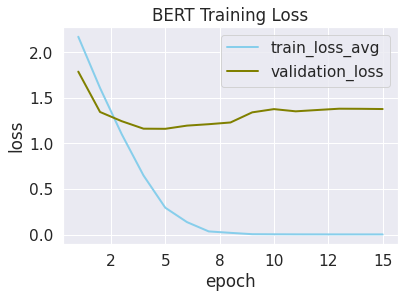

In [51]:
# Training loss plot

plt.plot( 'epoch', 'train_loss_avg', data=df_learning_curve,   color='skyblue', linewidth=2, label="train_loss_avg")
plt.plot( 'epoch', 'validation_loss', data=df_learning_curve,  color='olive', linewidth=2, label="validation_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('BERT Training Loss') 
plt.grid(True) 
#plt.ylim(0, 2.5)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.savefig(STATS_FOLDER + f'/BERT_training_loss.png')
plt.show() 

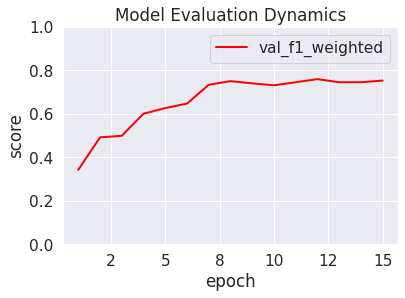

In [52]:
# Training Evaluation Dynamics plot
plt.plot( 'epoch', 'val_f1_weighted', data=df_learning_curve,  color='red', linewidth=2,  label="val_f1_weighted")
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()
plt.title('Model Evaluation Dynamics') 
plt.grid(True) 
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.ylim(0, 1)
plt.savefig(STATS_FOLDER + f'/BERT_eval_dynamics.png')
plt.show() 

## Step 11: Comparing with classic model baselines

In [53]:
import time
import seaborn as sn
from sklearn import svm
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Create feature vectors
tfidf_vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

tfidf_train_vectors = tfidf_vectorizer.fit_transform(train_df.feedback)
tfidf_val_vectors = tfidf_vectorizer.transform(val_df.feedback)
tfidf_test_vectors = tfidf_vectorizer.transform(test_df.feedback)

count_vectorizer = CountVectorizer()
count_train_vectors = count_vectorizer.fit_transform(train_df.feedback)
count_val_vectors = count_vectorizer.transform(val_df.feedback)
count_test_vectors = count_vectorizer.transform(test_df.feedback)

ml_tfidf_vectors = tfidf_test_vectors
ml_labels = test_df.label
ml_count_vectors = count_test_vectors

# Perform classification with SVM, kernel=linear
def run_classifier_experiment(input_train_vectors, train_labels, classifier = svm.SVC(kernel='linear')):
    t0 = time.time()
    classifier.fit(input_train_vectors, train_df.label)
    t1 = time.time()
    time_linear_train = t1-t0
    print("Training time: %fs" % (time_linear_train))
    return classifier

def run_classifier_test(classifier, input_val_vectors, val_labels, description="default_experiment"):
    t3 = time.time()
    val_prediction_linear = classifier.predict(input_val_vectors)
    t2 = time.time()  
    time_linear_predict = t2-t3
    # results
    print("Prediction time: %fs" % (time_linear_predict))
    svm_val_report = classification_report(val_labels, val_prediction_linear, output_dict=True)
    test_plot = sn.heatmap(pd.DataFrame(svm_val_report).iloc[:-1, :].T, annot=True,cmap="YlGnBu")
    test_plot.get_figure().savefig(STATS_FOLDER + f'/{description}.png')  
    return val_prediction_linear, val_labels

Training time: 0.002943s
Prediction time: 0.000378s


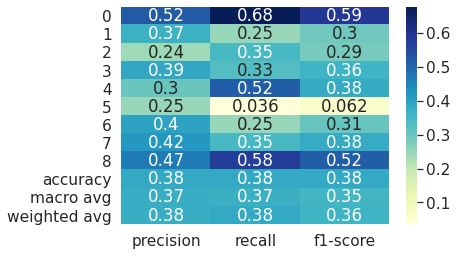

In [54]:
mnb = MultinomialNB(alpha=.2)
mnb_model = run_classifier_experiment(tfidf_train_vectors, train_df.label, classifier = mnb)
mnb_preds, mnb_labels = run_classifier_test(mnb_model, ml_tfidf_vectors, ml_labels, description="multinomialMB_alpha_.2_tfidf")

Training time: 0.004533s
Prediction time: 0.000833s


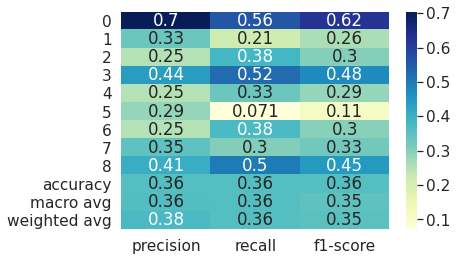

In [55]:
mnb = MultinomialNB(alpha=.2)
mnb_model = run_classifier_experiment(count_train_vectors, train_df.label, classifier = mnb)
mnb_preds, mnb_labels = run_classifier_test(mnb_model, ml_count_vectors, ml_labels, description="multinomialMB_alpha_.2_count")

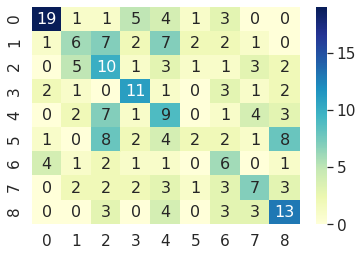

In [56]:
mnb_unique_labels = np.unique(test_df.label)
cm_mnb =  confusion_matrix(test_df.label, mnb_preds, labels=mnb_unique_labels)

sn.set(font_scale=1.4) # for label size
sn.heatmap(cm_mnb, annot=True, annot_kws={"size": 16},cmap="YlGnBu")

Training time: 0.353880s
Prediction time: 0.058785s


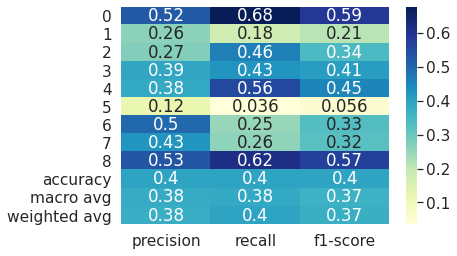

In [57]:
svm_linear = SVC(kernel='linear', C=1.1)
svm_linear_model = run_classifier_experiment(tfidf_train_vectors, train_df.label, classifier = svm_linear)
svm_linear_preds, svm_linear_labels = run_classifier_test(svm_linear_model, ml_tfidf_vectors, ml_labels, description="SVC_linear_C1.1_tfidf")

Training time: 0.422683s
Prediction time: 0.069210s


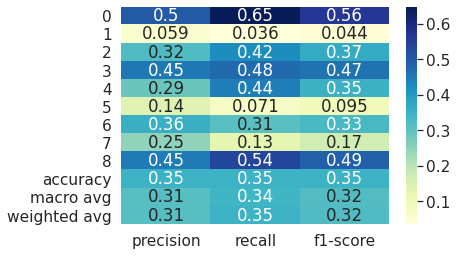

In [58]:
svm_linear = SVC(kernel='linear', C=1.1)
svm_linear_model = run_classifier_experiment(count_train_vectors, train_df.label, classifier = svm_linear)
svm_linear_preds, svm_linear_labels = run_classifier_test(svm_linear_model, ml_count_vectors, ml_labels, description="SVC_linear_C1.1_count")

Training time: 0.356866s
Prediction time: 0.059573s


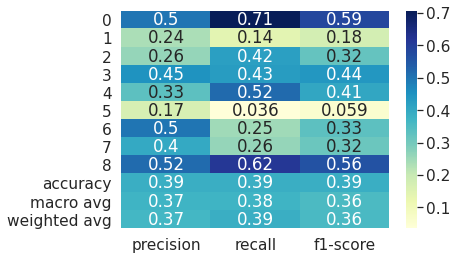

In [59]:
svm_default = SVC(C=2.5)
svm_default_model = run_classifier_experiment(tfidf_train_vectors, train_df.label, classifier = svm_default)
svm_default_preds, svm_default_labels = run_classifier_test(svm_default_model, ml_tfidf_vectors, ml_labels, description="SVC_default_C2.5_tfidf")

Training time: 0.428429s
Prediction time: 0.071874s


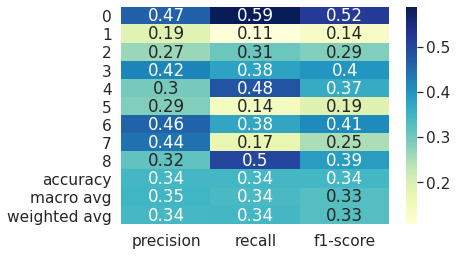

In [60]:
svm_default = SVC(C=2.5)
svm_default_model = run_classifier_experiment(count_train_vectors, train_df.label, classifier = svm_default)
svm_default_preds, svm_default_labels = run_classifier_test(svm_default_model, ml_count_vectors, ml_labels, description="SVC_default_C2.5_count")

Training time: 0.341155s
Prediction time: 0.102697s


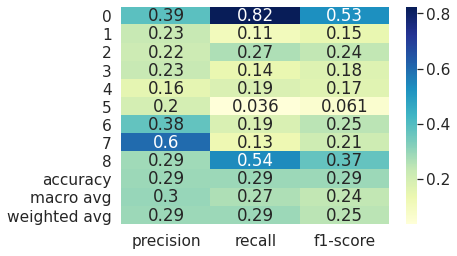

In [61]:
rf = RandomForestClassifier(n_jobs=-1, random_state=17)
rf_model = run_classifier_experiment(tfidf_train_vectors, train_df.label, classifier = rf)
rf_preds, rf_labels = run_classifier_test(rf_model, ml_tfidf_vectors, ml_labels, description="RandomForest_tfidf")

Training time: 0.340985s
Prediction time: 0.102589s


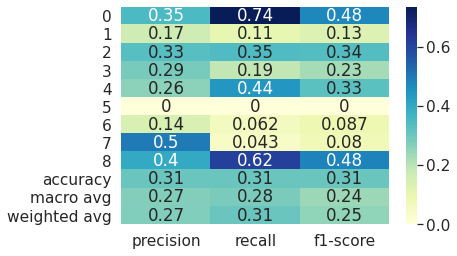

In [62]:
rf = RandomForestClassifier(n_jobs=-1, random_state=17)
rf_model = run_classifier_experiment(count_train_vectors, train_df.label, classifier = rf)
rf_preds, rf_labels = run_classifier_test(rf_model, ml_count_vectors, ml_labels, description="RandomForest_count")

Training time: 0.031590s
Prediction time: 0.000679s


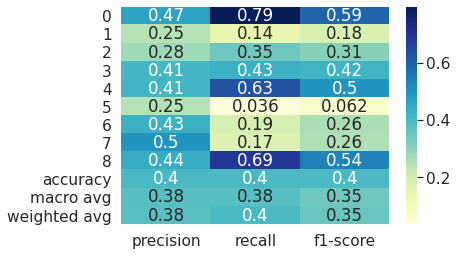

In [63]:
lr = LogisticRegression(fit_intercept=True, solver='liblinear')
lr_model = run_classifier_experiment(tfidf_train_vectors, train_df.label, classifier = lr)
lr_preds, lr_labels = run_classifier_test(lr_model, ml_tfidf_vectors, ml_labels, description="LogisticRegression_liblinear_tfidf")

Training time: 0.059466s
Prediction time: 0.000591s


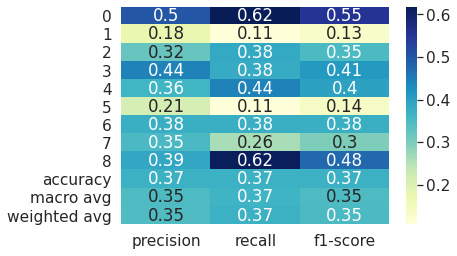

In [64]:
lr = LogisticRegression(fit_intercept=True, solver='liblinear')
lr_model = run_classifier_experiment(count_train_vectors, train_df.label, classifier = lr)
lr_preds, lr_labels = run_classifier_test(lr_model, ml_count_vectors, ml_labels, description="LogisticRegression_liblinear_count")

Training time: 0.099369s
Prediction time: 0.000723s


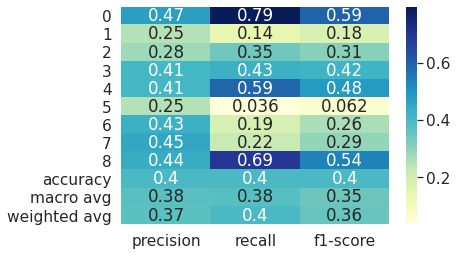

In [65]:
lr_2 = LogisticRegression(fit_intercept=True, solver='lbfgs')
lr2_model = run_classifier_experiment(tfidf_train_vectors, train_df.label, classifier = lr_2)
lr2_preds, lr2_labels = run_classifier_test(lr2_model, ml_tfidf_vectors, ml_labels, description="LogisticRegression_lbfgs_tfidf")

Training time: 0.777603s
Prediction time: 0.000409s


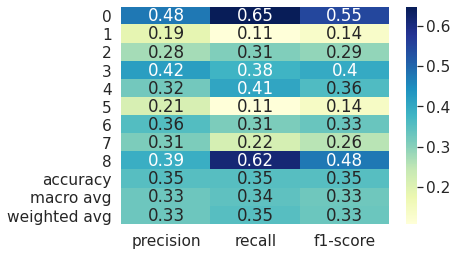

In [66]:
lr_2 = LogisticRegression(fit_intercept=True, solver='lbfgs', max_iter=200)
lr2_model = run_classifier_experiment(count_train_vectors, train_df.label, classifier = lr_2)
lr2_preds, lr2_labels = run_classifier_test(lr2_model, ml_count_vectors, ml_labels, description="LogisticRegression_lbfgs_count")